In [1]:
from qrel_reconstruction import *

In [2]:
system_instructions = """
Grade how relevant a passage is to a given query on a scale of 0-3 where:
  0 - Irrelevant: The passage has nothing to do with the query.
  1 - Related: The passage seems related to the query but does not answer it.
  2 - Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
  3 - Perfectly relevant: The passage is dedicated to the query and contains the exact answer with no additional information.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANCY: {Relevancy score}"""

system_instructions_reversed = """
Grade how relevant a passage is to a given query on a scale of 0-3 where:
  3 - Perfectly relevant: The passage is dedicated to the query and contains the exact answer with no additional information.
  2 - Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
  1 - Related: The passage seems related to the query but does not answer it.
  0 - Irrelevant: The passage has nothing to do with the query.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANCY: {Relevancy score}"""

In [3]:
# Run this cell to load dataset from csv if avialable. Otherwise, download and parse
msmarco_passage_v2 = load_dataset("data/msmarco-passage-v2-original.csv", "msmarco-passage-v2/trec-dl-2021")

,QueryID,DocumentID,Query,Document,Relevance Actual,Is Example
0,2082,msmarco_passage_01_552803451,At about what age do adults normally begin to ...,Why Is Lifting Weights Good for You? How Does ...,0,False
1,2082,msmarco_passage_01_790431544,At about what age do adults normally begin to ...,このサイトは「ととのうみすと」の口コミや効果について紹介します。. 30代になると肌のハリも...,0,False
2,2082,msmarco_passage_02_179207466,At about what age do adults normally begin to ...,"During childhood and early adulthood, more bon...",3,False
3,2082,msmarco_passage_02_179210433,At about what age do adults normally begin to ...,"They have smaller, thinner bones than men to b...",1,False
4,2082,msmarco_passage_02_179211281,At about what age do adults normally begin to ...,"By age 65 or 70, though, men and women lose bo...",1,False
...,...,...,...,...,...,...
10823,1040198,msmarco_passage_67_65022544,who is the final arbiter of florida law in ins...,Justices may remain in office until they resig...,0,False
10824,1040198,msmarco_passage_67_65385584,who is the final arbiter of florida law in ins...,Justices may remain in office until they resig...,0,False
10825,1040198,msmarco_passage_67_65676063,who is the final arbiter of florida law in ins...,Justices may remain in office until they resig...,0,False
10826,1040198,msmarco_passage_67_757560230,who is the final arbiter of florida law in ins...,"If the attorney engaged in criminal activity, ...",0,False


In [4]:
# Run zero-shot experiments
run_experiment(system_instructions, "data/msmarco-passage-v2-zeroshot.csv", 0, msmarco_passage_v2)

Done!


In [16]:
# Run zero-shot reversed experiments
run_experiment(system_instructions_reversed, "data/msmarco-passage-v2-zeroshot-reversed.csv", 0, msmarco_passage_v2)

Done!


In [6]:
# Run few-shot experiments
run_experiment(system_instructions, "data/msmarco-passage-v2-fewshot.csv", 4, msmarco_passage_v2)

Done!


In [7]:
# Run few-shot experiments
run_experiment(system_instructions_reversed, "data/msmarco-passage-v2-fewshot-reversed.csv", 4, msmarco_passage_v2)

Done!


Num Samples: 10828
              precision    recall  f1-score   support

           0       0.92      0.29      0.45      4338
           1       0.29      0.35      0.32      3063
           2       0.30      0.37      0.33      2341
           3       0.26      0.70      0.38      1086

    accuracy                           0.37     10828
   macro avg       0.44      0.43      0.37     10828
weighted avg       0.54      0.37      0.38     10828



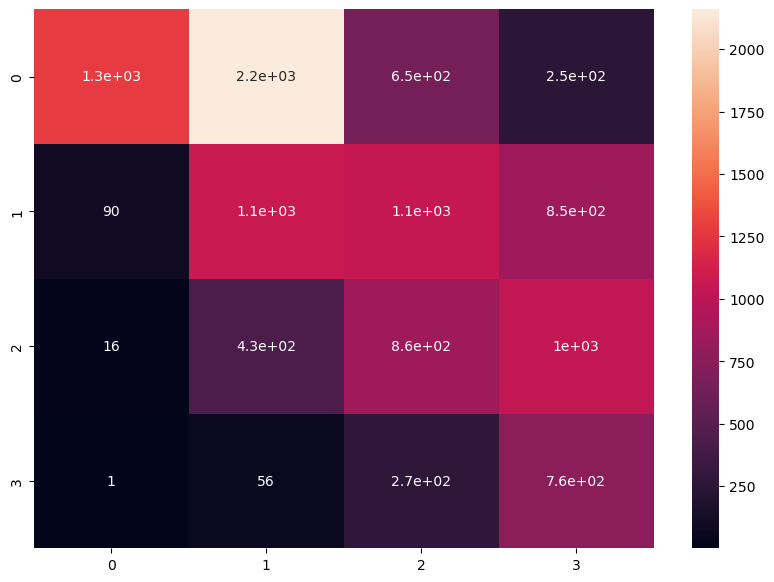

In [8]:
# Display metrics
zero_shot_predictions = load_experiments("data/msmarco-passage-v2-zeroshot.csv", msmarco_passage_v2)
prediction_metrics(zero_shot_predictions)


Num Samples: 10828
              precision    recall  f1-score   support

           0       0.89      0.44      0.58      4338
           1       0.33      0.31      0.32      3063
           2       0.31      0.46      0.37      2341
           3       0.30      0.64      0.41      1086

    accuracy                           0.43     10828
   macro avg       0.46      0.46      0.42     10828
weighted avg       0.55      0.43      0.45     10828



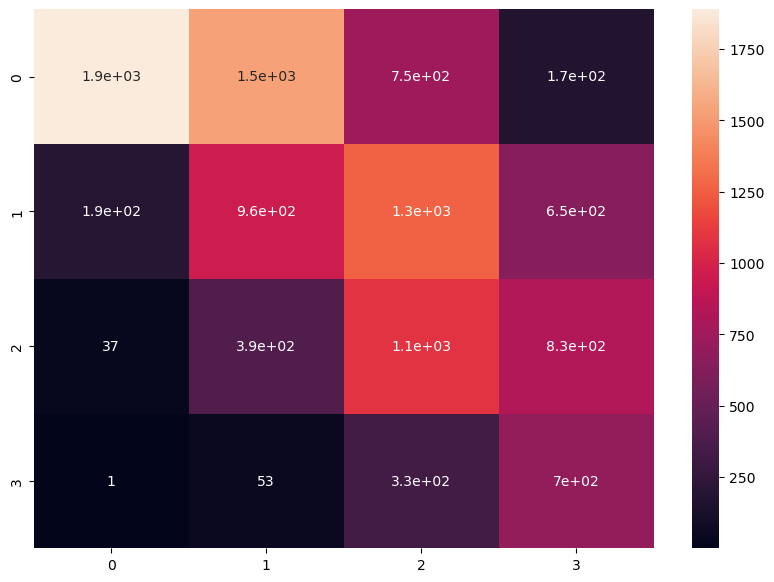

In [9]:
# Display metrics
zero_shot_reversed_predictions = load_experiments("data/msmarco-passage-v2-zeroshot-reversed.csv", msmarco_passage_v2)
prediction_metrics(zero_shot_reversed_predictions)

Num Samples: 10748
              precision    recall  f1-score   support

           0       0.85      0.33      0.48      4318
           1       0.28      0.31      0.29      3043
           2       0.31      0.33      0.32      2321
           3       0.26      0.77      0.39      1066

    accuracy                           0.37     10748
   macro avg       0.42      0.44      0.37     10748
weighted avg       0.51      0.37      0.38     10748



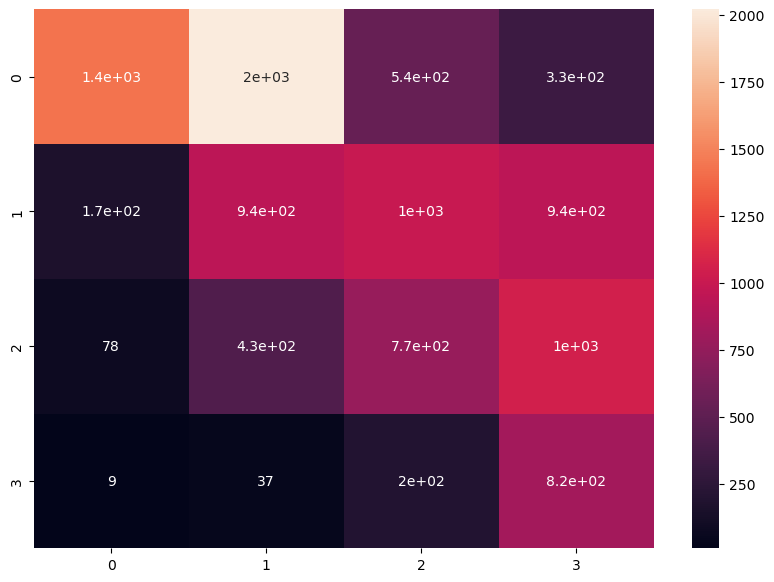

In [10]:
# Display metrics
few_shot_predictions = load_experiments("data/msmarco-passage-v2-fewshot.csv", msmarco_passage_v2)
prediction_metrics(few_shot_predictions)

Num Samples: 10748
              precision    recall  f1-score   support

           0       0.80      0.55      0.65      4318
           1       0.34      0.25      0.29      3043
           2       0.29      0.39      0.34      2321
           3       0.28      0.63      0.39      1066

   micro avg       0.44      0.44      0.44     10748
   macro avg       0.43      0.46      0.42     10748
weighted avg       0.51      0.44      0.45     10748



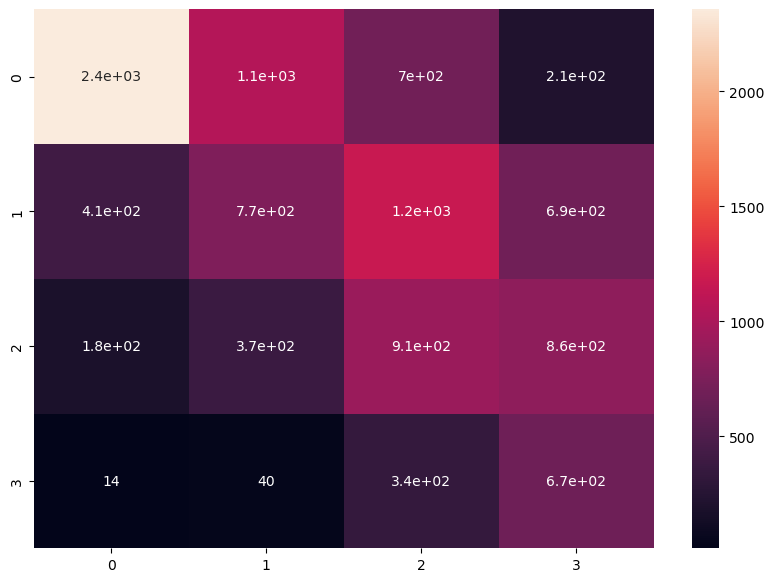

In [11]:
# Display metrics
few_shot_reversed_predictions = load_experiments("data/msmarco-passage-v2-fewshot-reversed.csv", msmarco_passage_v2)
prediction_metrics(few_shot_reversed_predictions)


In [12]:
# Combine all of the experiments into a single file
combined_dataset = pd.concat([msmarco_passage_v2, zero_shot_predictions['Relevance Predicted'], zero_shot_reversed_predictions['Relevance Predicted'], few_shot_predictions['Relevance Predicted'], few_shot_reversed_predictions['Relevance Predicted']], axis=1)
combined_dataset = combined_dataset.set_axis(["QueryID", "DocumentID", "Query", "Document", "Actual", "Is Example", "Zeroshot", "Zeroshot Reversed", "Fewshot", "Fewshot Reversed"], axis=1)
combined_dataset.to_csv(Path('data/msmarco-passage-v2-reconstruction.csv'))